In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import geopandas as gpd
import glob
from fos.dirs import basedir
from matplotlib.colors import Normalize # , DivergingNorm
import cmcrameri.cm as ccm
from matplotlib.cm import ScalarMappable


outputsdir = '/global/cfs/cdirs/m4099/fate-of-snotel/wrfdata/umital/Fig4_results/'

from fos.dirs import projectdir, basedir, coorddir
# from fos.data import snotel_no_ak
plt.style.use('style.mplstyle')
plt.rcParams['font.family'] = 'sans-serif'

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
huc2 = gpd.read_file(f'{basedir}spatialdata/huc2.shp')
coords = xr.open_dataset(f'{coorddir}wrfinput_d02')
states = gpd.read_file('cb_2018_us_state_5m.shp')

/global/homes/c/cowherd/.conda/envs/fos/lib/python3.11/site-packages/pyproj/__init__.py:90: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
glob.glob(outputsdir +'*')

['/global/cfs/cdirs/m4099/fate-of-snotel/wrfdata/umital/Fig4_results/Err_allmodels_corrupteddata.nc',
 '/global/cfs/cdirs/m4099/fate-of-snotel/wrfdata/umital/Fig4_results/RF_SynthErr_predictions.nc',
 '/global/cfs/cdirs/m4099/fate-of-snotel/wrfdata/umital/Fig4_results/basin_masks_filtered.nc',
 '/global/cfs/cdirs/m4099/fate-of-snotel/wrfdata/umital/Fig4_results/RF_SynthErr_predictions_allyears.nc',
 '/global/cfs/cdirs/m4099/fate-of-snotel/wrfdata/umital/Fig4_results/LR_SynthErr_predictions.nc',
 '/global/cfs/cdirs/m4099/fate-of-snotel/wrfdata/umital/Fig4_results/LR_SynthErr_predictions_allyears.nc',
 '/global/cfs/cdirs/m4099/fate-of-snotel/wrfdata/umital/Fig4_results/Fig4_Unet_preds_test']

In [3]:
huc6 = gpd.read_file(f'{basedir}spatialdata/huc6.shp')
h6masks = xr.open_dataset(f'{outputsdir}basin_masks_filtered.nc')
#rf_err_pred = xr.open_dataset(f'{outputsdir}RF_SynthErr_predictions_allyears.nc').rename({'__xarray_dataarray_variable__': 'swe'})
#lr_err_pred = xr.open_dataset(f'{outputsdir}LR_SynthErr_predictions_allyears.nc').rename({'__xarray_dataarray_variable__': 'swe'})
sweMax = xr.open_dataset('snowMax.nc').compute().rename({'__xarray_dataarray_variable__': 'swe'})
basin_masks = xr.open_dataset(f'{outputsdir}basin_masks_filtered.nc')
swe_wrf = sweMax.copy()
# swe_wrf['gcm'] = rf_err_pred['gcm']

In [4]:
err = xr.open_dataset(f'{outputsdir}/Err_allmodels_corrupteddata.nc').rename({'__xarray_dataarray_variable__':'value'})
exclude_value = "Northern Oregon Coastal"

mask = err["basin"] != exclude_value
err = err.where(mask, drop=True)


In [5]:
models = err.model.values
gcms = err.gcm.values
basins = err.basin.values
years = err.test_year.values
datas = err.pred_combo.values
metrics = err.metric.values


In [6]:
#datas = ['Data_1', 'Data_2', 'Data_3', 'Data_4','Data_5']
#basin_names = h6masks['basin'].data
#basin_names = basin_names[basin_names != 'Northern Oregon Coastal']
norm = Normalize(vmin=0, vmax=1)
colormap =  ccm.acton_r #plt.cm.get_cmap("viridis")  
colormap = plt.cm.get_cmap('plasma_r')
sm = ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])

norm2 = Normalize(vmin=-1, vmax=1)
colormap2 = ccm.roma # plt.cm.get_cmap("BrBG")  
sm2 = ScalarMappable(cmap=colormap, norm=norm)
sm2.set_array([])



In [7]:
##just generate the numbers and save it and then plot them in the second oe
outdatas = {}
for i,data in enumerate(datas):
    outdatas[i] = {}
    for j,model in enumerate(models):
        outdatas[i][model] = []
        for n in range(len(basins)):
            name = basins[n]
            mydata = np.nanmean(err.sel(metric = 'r2').sel(basin = name).sel(pred_combo = data).sel(model = model).mean(dim = 'gcm')['value'].values)
            basin = huc6[huc6.name == name]
            outdatas[i][model].append(mydata)


In [8]:
##just generate the numbers and save it and then plot them in the second oe
outrmse = {}
for i,data in enumerate(datas):
    outrmse[i] = {}
    for j,model in enumerate(models):
        outrmse[i][model] = []
        for n in range(len(basins)):
            name = basins[n]
            mydata = np.nanmean(err.sel(metric = 'rmse').sel(basin = name).sel(pred_combo = data).sel(model = model).mean(dim = 'gcm')['value'].values)
            basin = huc6[huc6.name == name]
            outrmse[i][model].append(mydata)

In [9]:
geometry = []
for name in basins:
    idx = huc6[huc6.name == name].index[0]
    geometry.append(huc6[huc6.name == name].loc[idx]['geometry'])
plotdata = gpd.GeoDataFrame({'basin_name':basins, 'geometry':geometry})

for i,data in enumerate(datas):
    for j,model in enumerate(models):
        colname = f'{data}_{model}'
        plotdata[colname] = outdatas[i][model]
    plotdata[f'{data}_diff'] = np.array(outdatas[i]['linreg']) - np.array(outdatas[i]['RF'] )

In [10]:
import warnings
from shapely import speedups  # Import speedups module from Shapely

# Check if Shapely speedups are available
if speedups.available:
    warnings.filterwarnings("ignore", category=DeprecationWarning)


In [11]:
warnings.filterwarnings("ignore")


In [12]:
groups = {'grp1': ['Data_1', 'Data_2'],
          'grp2': ['Data_3', 'Data_4'],
          'grp3': ['Data_5']}
def plot_model_grp_ax(model, grp, ax):
    tmp_data = err.sel(metric = 'r2').sel(pred_combo = groups[grp]).sel(model = model).mean(dim = 'gcm').mean(dim = 'pred_combo')
    yearmeans = np.nanmean(np.array(tmp_data.value), axis =1)

    tmp_gdf = gpd.GeoDataFrame({'mean':yearmeans}, geometry = geometry)
    tmp_gdf.plot(ax=ax, column = 'mean', vmin = 0, vmax = 1)
    return


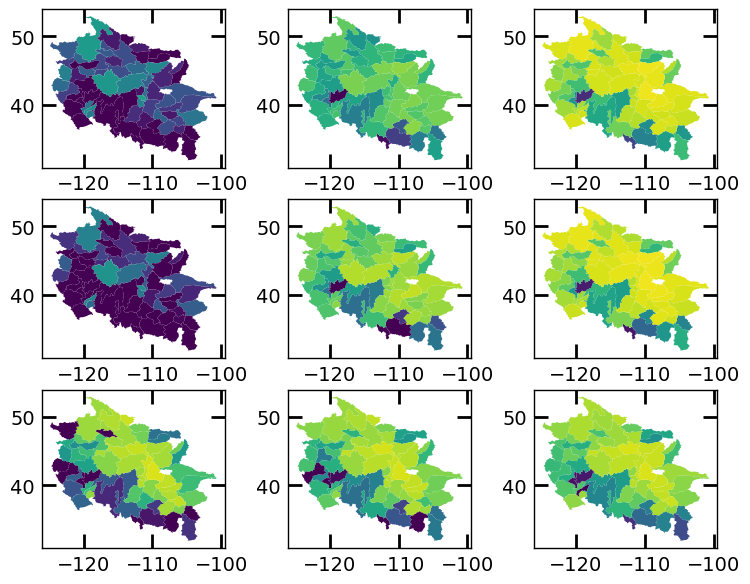

In [13]:
fig, axs = plt.subplots(3,3)
for i,model in enumerate(models):
    for j,grp in enumerate(groups):
        ax = axs[i,j]
        plot_model_grp_ax(model, grp, ax)

In [14]:
import pandas as pd
groups = {
    'RF_data_1_2': ['Data_1_RF', 'Data_2_RF'],
    'RF_data_3_4': ['Data_3_RF', 'Data_4_RF'],
    'RF_data_5': ['Data_5_RF'],
    'linreg_data_1_2': ['Data_1_linreg', 'Data_2_linreg'],
    'linreg_data_3_4': ['Data_3_linreg', 'Data_4_linreg'],
    'linreg_data_5': ['Data_5_linreg'],
    'Unet_data_1_2': ['Data_1_Unet', 'Data_2_Unet'],
    'Unet_data_3_4': ['Data_3_Unet', 'Data_4_Unet'],
    'Unet_data_5': ['Data_5_Unet']
}

# Calculate the means for each group and store them in a new DataFrame
means_data = {}
for group_name, group_columns in groups.items():
    means_data[group_name] = plotdata[group_columns].mean(axis=1)

grouped_df = pd.DataFrame(means_data)
grouped_df['basin_name'] = plotdata['basin_name']
grouped_gdf = gpd.GeoDataFrame(grouped_df, geometry = plotdata.geometry)


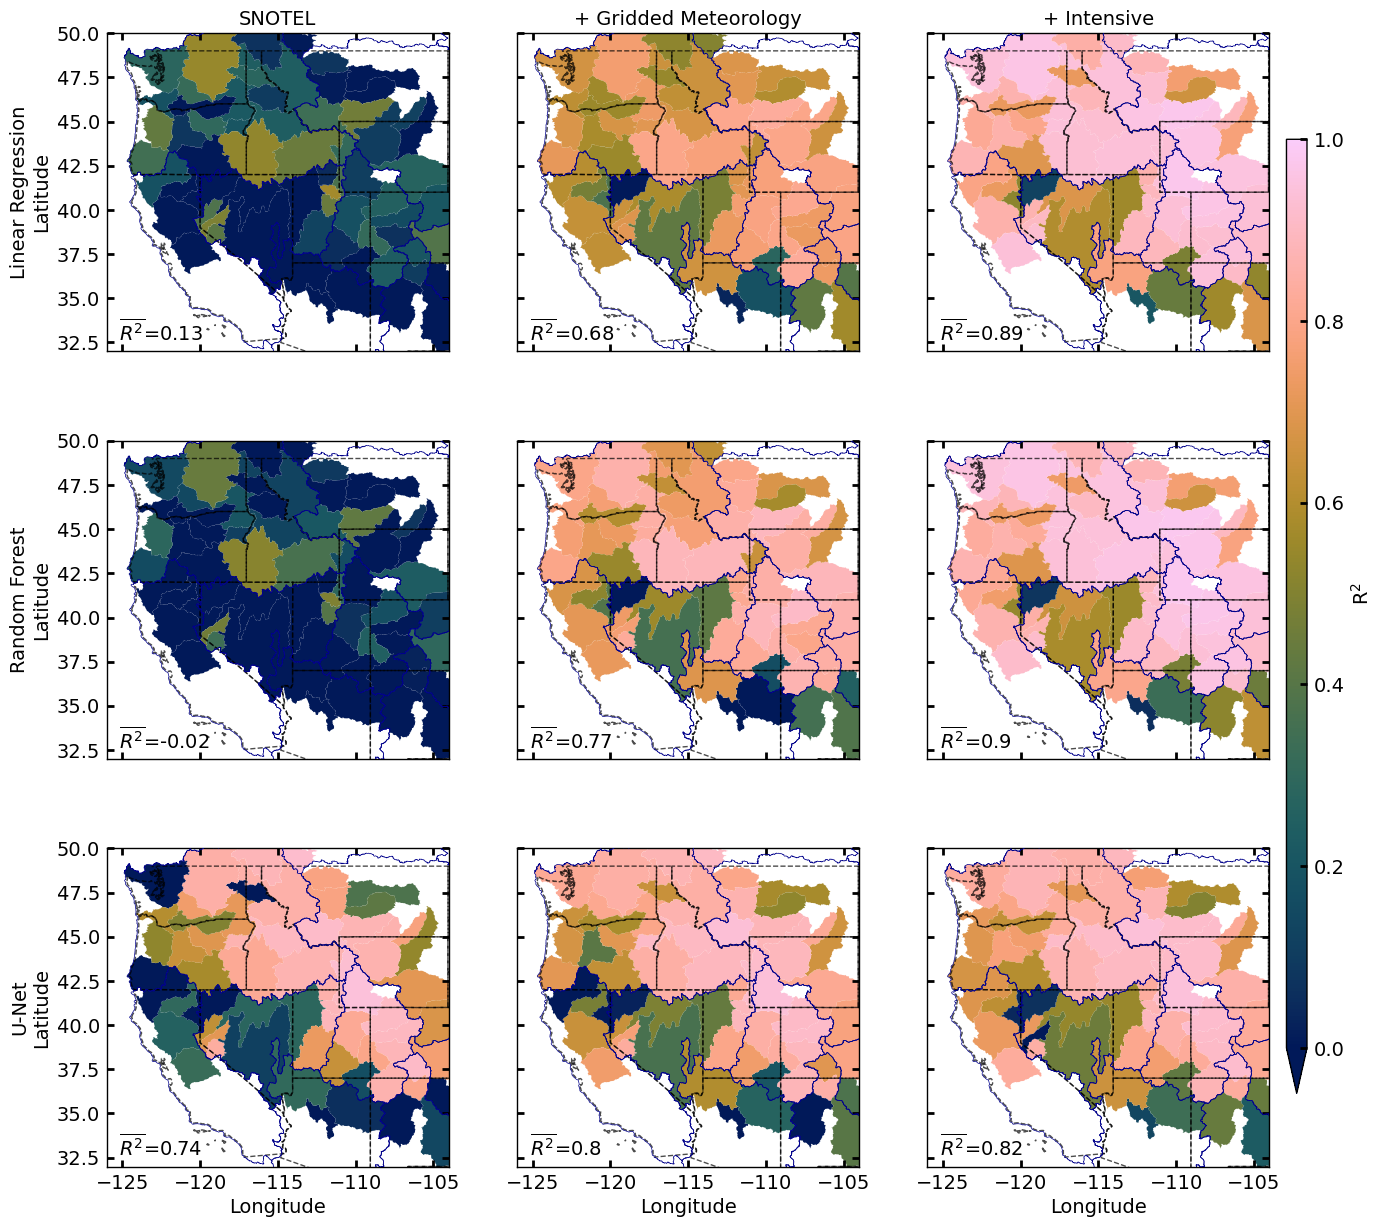

CPU times: user 1min 59s, sys: 1.53 s, total: 2min 1s
Wall time: 2min


In [15]:
%%time
vmin = 0
vmax = 1
norm = Normalize(vmin=vmin, vmax=vmax)
#colormap =  ccm.acton_r #plt.cm.get_cmap("viridis")  
colormap = ccm.batlow
# colormap = plt.cm.get_cmap('jet')
sm = ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])



labels_model = {'linreg': 'Linear Regression', 'RF': 'Random Forest', 'Unet': 'U-Net'} 
titles_datas = {'data_1_2': 'SNOTEL', 'data_3_4': '+ Gridded Meteorology', 'data_5': '+ Intensive'}
plt.rcParams['xtick.major.size'] = 5 
plt.rcParams['ytick.major.size'] = 5
## 1 min 37 seconds
grouptypes = ['data_1_2', 'data_3_4', 'data_5']
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
basincolor = 'darkblue'
for i in range(3):
    data = grouptypes[i] 
    for j, model in enumerate(['linreg', 'RF', 'Unet']):
        ax = axs[j, i]
        colname = f'{model}_{data}'
        cax = grouped_gdf.plot(column=colname, cmap=colormap, ax=ax, vmin=vmin, vmax=vmax, legend=False)
        r2 = round(np.nanmedian(grouped_gdf[colname][grouped_gdf[colname] >-1e2]),2)
        ax.text(-125.2, 32.55, r'$\overline{R^{2}}$='+f'{r2}')
        
        if (i == 2) and (j ==2): 
                cb = ax.scatter([0,0] , [1,1],c = [0,1], cmap = colormap, vmin = vmin, vmax = vmax)                
                cax = ax.inset_axes([1.05, 0.23, 0.06, 3])    ## x index , y index, width , length     
                cbar = plt.colorbar(cb, cax=cax, pad=0.1, orientation='vertical',
                                     extend='min', label = r'R$^2$')
                
        
        
        if j == 0: ax.set_title(titles_datas[data], fontsize = 14)
        if i > 0: ax.set_yticklabels([])
        else: ax.set_ylabel(f'{labels_model[model]}\nLatitude')
        if j  < 2 : ax.set_xticklabels([])
        else: ax.set_xlabel('Longitude')
        
for ax in axs.flatten():
    
    huc2.boundary.plot(ax=ax, linewidth=0.5, color=basincolor, label='Basin boundary', zorder=3)
    states.boundary.plot(ax=ax, linewidth=1, color='black', alpha=0.7, linestyle='--')
        
    ax.set_xlim((-126, -104))
    ax.set_ylim((32, 50))



plt.show()


In [21]:
np.nanmean(grouped_df[colname])

0.6512980524632657

In [ ]:
%%time
## 6min 40s
fig, axs = plt.subplots(3, 5, figsize=(25, 15))
basincolor = 'darkblue'

for ax in axs.flatten():
    huc2.boundary.plot(ax=ax, linewidth=0.5, color=basincolor, label='Basin boundary', zorder=3)
    states.boundary.plot(ax=ax, linewidth=1, color='black', alpha=0.7, linestyle='--')

for i in range(5):
    data = datas[i]
    for j, model in enumerate(['linreg', 'RF']):
        ax = axs[j, i]
        colname = f'{data}_{model}'
        cax = plotdata.plot(column=colname, cmap=colormap, ax=ax, vmin=0, vmax=1, legend=False)
        if i == 4: 
            if j == 1:
                cb = ax.scatter([0,0] , [1,1],c = [0,1], cmap = colormap, vmin = 0, vmax = 1)                
                cax = ax.inset_axes([1.05, 0.33, 0.06, 2])        
                cbar = plt.colorbar(cb, cax=cax, pad=0.1, orientation='vertical',
                                     extend='both', label = r'R$^2$')
                cbar.set_ticklabels([])
                
        
        ax.set_xlim((-125, -104))
        ax.set_ylim((32, 50))

    ax2 = axs[2, i]
    colname = f'{data}_diff'
    plotdata.plot(column=colname, vmin=-0.5, vmax=0.5, ax=ax2, cmap=colormap2, legend = False)
    cb = ax2.scatter([0,0] , [1,1],c = [0,1], cmap = colormap2, vmin = -0.5, vmax = 0.5)   
    if i == 4:
        cax2 = ax2.inset_axes([1.05, 0, 0.06, 1])        
        cbar = plt.colorbar(cb, cax=cax2, pad=0.1, orientation='vertical',
                             extend='both', label = 'Difference')
        cbar.set_ticklabels([])
    ax2.set_xlim((-125, -104))
    ax2.set_ylim((32, 50))

# plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
diffs = []
rmses = []
for i in range(5):
    squared_diffs = (rf_err_pred['swe'][:, 20:, i , :, :] - swe_wrf['swe'][:, :, :, :]) ** 2
    diffs.append(squared_diffs)
    rmse_values = np.sqrt(np.mean(squared_diffs, axis=1))
    rmses.append(rmse_values)


In [ ]:
import numpy as np
import xarray as xr
from sklearn.metrics import mean_squared_error, r2_score


rf_data = rf_err_pred
lr_data = lr_err_pred
# Initialize lists to store computed values
values = []

# Create lists for dimensions
# basin_values = range(68)
gcm_values = rf_data['gcm'].values
test_year_values = rf_data['test_year'].values
model_values = ['RF', 'LR']
pred_combo_values = rf_data['pred_combo'].values
metric_values = ['rmse', 'r2']
basin_values = basin_masks.basin.values

# Iterate through each combination of dimensions
for basin in basin_values:
    for gcm in gcm_values:
        for test_year in test_year_values:
            for model in model_values:
                for pred_combo in pred_combo_values:
                    for metric in metric_values:
                        wrf_data = xr.open_dataset('snowMax.nc').compute().rename({'__xarray_dataarray_variable__': 'swe'})
                        wrf_data['gcm'] = rf_err_pred['gcm']

                        if model == 'RF':
                            data1 = rf_data.copy()
                            data1_mask = data1.sel(gcm=gcm, test_year=test_year, pred_combo=pred_combo)['swe'].values
                        elif model == 'LR':
                            data1 =lr_data.copy()
                            data1_mask = data1.sel(gcm=gcm, test_year=test_year, pred_combo=pred_combo)['swe'].values
                        data2 = wrf_data.copy()
                        data2_mask = data2.sel(gcm=gcm, year=test_year)['swe'].values
                        
                        # Apply the basin mask
                        mask = basin_masks.sel(basin = basin).basin_masks.values.astype(bool)
                        data1_mask[~mask] = np.nan
                        data2_mask[~mask] = np.nan
                        
                        # Calculate RMSE and R2
                        if metric == 'rmse':
                            value = np.sqrt(mean_squared_error(data2_mask[mask], data1_mask[mask]))
                        else:
                            value = r2_score(data2_mask[mask].flatten(), data1_mask[mask].flatten())
                        
                        # Store the values
                        values.append(value)
    values_array = np.array(values).reshape(1, len(gcm_values), len(test_year_values),
                                        len(model_values), len(pred_combo_values), len(metric_values))

    comparison_dataset = xr.Dataset(
        {'values': (('basin', 'gcm', 'test_year', 'model', 'pred_combo', 'metric'), values_array)},
        coords={'basin': [basin], 'gcm': gcm_values, 'test_year': test_year_values,
                'model': model_values, 'pred_combo': pred_combo_values, 'metric': metric_values})

    comparison_dataset.to_netcdf(f'err_{basin}.nc')

In [ ]:
norms = []
for year in err['test_year'].values:
    val= sweMax.sel(year = year).mean()['swe'].values.flatten()[0]
    norms.append(val)

In [ ]:
datas = ['Data1', 'Data2', 'Data3', 'Data4','Data5']
colors = {'lr':'darkblue',
          'rf': 'red'}
fig,ax = plt.subplots(1,1, figsize =(5,5))
mydata = err.sel(metric = 'rmse').mean(dim = 'basin').sum(dim = 'gcm')
lr = mydata.sel(model = 'linreg')
rf = mydata.sel(model = 'RF')
ax.plot(datas, lr['value'][0:10,:].mean(dim = 'test_year').data, label = 'lr', color = colors['lr'], linestyle = ':')
ax.plot(datas, rf['value'][0:10,:].mean(dim = 'test_year').data, label = 'rf', color = colors['rf'], linestyle = ':')
ax.plot(datas, lr['value'][-10:,:].mean(dim = 'test_year').data,color = colors['lr'])
ax.plot(datas, rf['value'][-10:,:].mean(dim = 'test_year').data, color = colors['rf'])
ax.set_ylabel('RMSE [mm]')
ax.legend()
plt.show()

In [ ]:
datas = ['Data_1', 'Data_2', 'Data_3', 'Data_4','Data_5']
colors = {'lr':'darkblue',
          'rf': 'red'}
fig,ax = plt.subplots(1,1, figsize =(5,5))
mydata = err.sel(metric = 'rmse').mean(dim = 'basin').sum(dim = 'gcm')
lr = mydata.sel(model = 'linreg')
rf = mydata.sel(model = 'RF')
ax.plot(datas, lr['value'][0:10,:].mean(dim = 'test_year').data, label = 'lr', color = colors['lr'], linestyle = ':')
ax.plot(datas, rf['value'][0:10,:].mean(dim = 'test_year').data, label = 'rf', color = colors['rf'], linestyle = ':')
ax.plot(datas, lr['value'][-10:,:].mean(dim = 'test_year').data,color = colors['lr'])
ax.plot(datas, rf['value'][-10:,:].mean(dim = 'test_year').data, color = colors['rf'])
ax.set_ylabel('RMSE [mm]')
ax.legend()
plt.show()

In [ ]:
mydata = err.sel(metric = 'rmse').mean(dim = 'basin').sum(dim = 'gcm')
lr = mydata.sel(model = 'linreg')
rf = mydata.sel(model = 'RF')

normed_rf_rmse = []
normed_lr_rmse = []

for data in datas:
    tmp = rf.sel(pred_combo =data)
    normed_rf_rmse.append(tmp['value'].values / norms)
    tmp = lr.sel(pred_combo =data)
    normed_lr_rmse.append(tmp['value'].values / norms)

normed_rf_rmse_arr = np.array(normed_rf_rmse)
normed_lr_rmse_arr = np.array(normed_lr_rmse)

In [ ]:
mydata = err.sel(metric = 'r2').mean(dim = 'basin').sum(dim = 'gcm')
lr = mydata.sel(model = 'linreg')
rf = mydata.sel(model = 'RF')

normed_rf_r2 = []
normed_lr_r2 = []

for data in datas:
    tmp = rf.sel(pred_combo=data)
    normed_rf_r2.append(tmp['value'].values) # / norms)
    tmp = lr.sel(pred_combo =data)
    normed_lr_r2.append(tmp['value'].values) # / norms)

normed_rf_r2_arr = np.array(normed_rf_r2)
normed_lr_r2_arr = np.array(normed_lr_r2)

In [ ]:
fig,ax = plt.subplots(1,1, figsize =(5,5))
ax.plot(datas, np.nanmean(normed_lr_rmse_arr[:,0:10],axis =1), color = colors['lr'], linestyle = ':')
ax.plot(datas,np.nanmean(normed_rf_rmse_arr[:,0:10],axis =1), color = colors['rf'], linestyle = ':')
ax.plot(datas,np.nanmean(normed_lr_rmse_arr[:,-10:],axis =1),color = colors['lr'], label = 'lr')
ax.plot(datas, np.nanmean(normed_rf_rmse_arr[:,-10:],axis =1), color = colors['rf'], label = 'rf')
ax.set_ylabel('rRMSE [mm/mm]')
ax.legend()
plt.show()

In [ ]:
fig,ax = plt.subplots(1,1, figsize =(5,5))
ax.plot(datas, np.nanmean(normed_lr_r2_arr[:,0:15],axis =1), color = colors['lr'], linestyle = ':')
ax.plot(datas,np.nanmean(normed_rf_r2_arr[:,0:16],axis =1), color = colors['rf'], linestyle = ':')
ax.plot(datas,np.nanmean(normed_lr_r2_arr[:,16:],axis =1),color = colors['lr'], label = 'lr')
ax.plot(datas, np.nanmean(normed_rf_r2_arr[:,16:],axis =1), color = colors['rf'], label = 'rf')
ax.set_ylabel('r2 [mm/mm]')
ax.legend()
plt.show()

In [ ]:
fig,ax=plt.subplots()
for i in range(5):
    ax.plot(normed_lr_r2_arr[i,0:6])
plt.show()
fig,ax=plt.subplots()
for i in range(5):
    ax.plot(normed_lr_r2_arr[i,])

In [ ]:
def normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = -1 + 2 * ((data - min_val) / (max_val - min_val))
    return normalized_data
def normalize_with_plotting_position(data):
    n = len(data)
    sorted_data = np.sort(data)
    normalized_data = (np.arange(1, n + 1) - 0.5) / n
    return normalized_data

def normalize_with_log(data):
    min_value = np.abs(np.nanmin(data))
    shifted_data = data + min_value + 1
    log_normalized_data = np.log(shifted_data)
    return log_normalized_data

# Example usage
   
fig,ax=plt.subplots()
for i in range(5):
    data = normalize_with_plotting_position(normed_lr_r2_arr[i,])
    ax.plot(data)
plt.show()

fig,ax=plt.subplots()
for i in range(5):
    data = normalize_with_log(normed_lr_r2_arr[i,])
    ax.plot(data)
plt.show()


In [ ]:
def getslope(data_variable):
    x = data_variable.test_year.values
    y = data_variable.values
    slope = theilslopes(y, x).slope
    return slope


In [ ]:
from scipy.stats import theilslopes
r2slopes_lr = [] 
r2slopes_rf = []
for i in range(len(basin_names)):
    name = basin_names[i]
    basin = huc6[huc6.name == name]
    r2 = err.sel(metric = 'r2').sel(basin = name).sel(pred_combo = 'Data_1').sel(model = 'linreg').mean(dim = 'gcm')
    data_variable = r2['value']
    slope = getslope(data_variable)
    r2slopes_lr.append(slope)
    r2 = err.sel(metric = 'r2').sel(basin = name).sel(pred_combo = 'Data_1').sel(model = 'RF').mean(dim = 'gcm')
    data_variable = r2['value']
    slope = getslope(data_variable)
    r2slopes_rf.append(slope)

def plot_slopes(slopes):
    q25, q75 = np.percentile(slopes, [25, 75])
    iqr = q75 - q25
    lower_bound = q25 - 1.5 * iqr
    upper_bound = q75 + 1.5 * iqr

    # Remove outliers
    filtered_slopes = [slope for slope in slopes if lower_bound <= slope <= upper_bound]

    limit = np.nanmax(np.abs([min(filtered_slopes), max(filtered_slopes)]))
    norm = Normalize(vmin=-limit, vmax=limit)

    colormap = plt.cm.get_cmap("coolwarm_r")  # Choose any colormap you prefer
    sm = ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])

    ## make a map with r2 values slopes for data1 only
    fig,ax = plt.subplots()
    for i in range(len(basin_names)):
        name = basin_names[i]
        slope = slopes[i]
        basin = huc6[huc6.name == name]
        color = colormap(norm(slope))  
        basin.plot(ax=ax, color = color)
    plt.show()
plot_slopes(r2slopes_rf)
plot_slopes(r2slopes_lr)

In [ ]:
r2slopes = {} 
r2diff = {}
for data in datas:
    r2slopes[data] = {}
    r2diff[data] = {}
    for model in ['linreg','RF']:
        r2slopes[data][model] = []
        r2diff[data][model] = []
        for i in range(len(basin_names)):
            name = basin_names[i]
            r2 = err.sel(metric = 'r2').sel(basin = name).sel(pred_combo = data).sel(model = model).mean(dim = 'gcm')
            data_variable = r2['value']
            slope = getslope(data_variable)
            r2slopes[data][model].append(slope)
            diff = np.nanmean(data_variable[0:5]) - np.nanmean(data_variable[-5:])
            r2diff[data][model].append(diff)

In [ ]:
for data in datas:
    for model in ['linreg','RF']:
        slopes = r2slopes[data][model]
        print(data, model)
        plot_slopes(slopes)
        

In [ ]:
for data in datas:
    for model in ['linreg','RF']:
        slopes = r2diff[data][model]
        print(data, model)
        plot_slopes(slopes)
        

In [ ]:
## re-do it where you just generate the numbers and save it and then plot them in the second oe

norm = Normalize(vmin=0, vmax=1)
colormap = plt.cm.get_cmap("viridis")  # Choose any colormap you prefer
sm = ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
fig,axs = plt.subplots(2,5,figsize = (15,10))
outdatas = {}
for i,data in enumerate(datas):
    outdatas[i] = {}
    for j,model in enumerate(['linreg', 'RF']):
        outdatas[i][model] = []
        ax = axs[j,i]
        for n in range(len(basin_names)):
            name = basin_names[n]
            mydata = np.nanmean(err.sel(metric = 'r2').sel(basin = name).sel(pred_combo = data).sel(model = model).mean(dim = 'gcm')['value'].values[-5:])
            basin = huc6[huc6.name == name]
            outdatas[i][model].append(mydata)
            color = colormap(norm(mydata))  
            basin.plot(ax=ax, color = color)
        ax.set_title(f'{data} {model}')
plt.show()


In [ ]:
for i,data in enumerate(datas):
    for j,model in enumerate(['linreg', 'RF']):
        colname = f'{data}_{model}'
        plotdata[colname] = outdatas[i][model]
    plotdata[f'{data}_diff'] = np.array(outdatas[i]['linreg']) - np.array(outdatas[i]['RF'] )

In [ ]:
%%time
# Choose a column for coloring
color_column = 'Data_1_linreg'  # Change this to the name of the column you want to use

# Create a colormap
cmap = 'viridis'  # Choose a colormap name

# Create a GeoDataFrame plot
fig, ax = plt.subplots(figsize=(10, 8))
plotdata.plot(column=color_column, cmap=cmap, ax=ax, vmin = 0, vmax =1, legend=True)

# Customize the plot
ax.set_title(f'HUC6 Map - Color by {color_column}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()


In [ ]:
%%time
## 22 seconds when done this way without the first for loop (geographic obejects)
## with the first for loop it takes a loooooong time ?? 
fig,axs = plt.subplots(3,5,figsize = (25,15))
basincolor = 'darkblue'


for ax in axs.flatten():
    huc2.boundary.plot(ax=ax, linewidth=0.5, color=basincolor, label='Basin boundary', zorder=3)
    states.boundary.plot(ax=ax, linewidth=1, color='black', alpha=0.7, linestyle='--')

for i in range(5):
    data = datas[i]
    for j,model in enumerate(['linreg', 'RF']):
        ax = axs[j,i]
        colname = f'{data}_{model}'
        plotdata.plot(column=colname, cmap=colormap, ax=ax, vmin = 0, vmax =1, legend=True)
        # ax.set_title(f'{data} {model}')
        ax.set_xlim((-125,-104))
        ax.set_ylim((32,50))
       
    ax2 = axs[2,i]
    colname = f'{data}_diff'
    plotdata.plot(column =colname,vmin = -0.5, vmax = .5, ax=ax2, cmap = colormap2)
    ax2.set_xlim((-125,-104))
    ax2.set_ylim((32,50))
                      
plt.show()


In [ ]:
%%time
## 6min 40s
fig, axs = plt.subplots(3, 5, figsize=(25, 15))
basincolor = 'darkblue'

for ax in axs.flatten():
    huc2.boundary.plot(ax=ax, linewidth=0.5, color=basincolor, label='Basin boundary', zorder=3)
    states.boundary.plot(ax=ax, linewidth=1, color='black', alpha=0.7, linestyle='--')

for i in range(5):
    data = datas[i]
    for j, model in enumerate(['linreg', 'RF']):
        ax = axs[j, i]
        colname = f'{data}_{model}'
        cax = plotdata.plot(column=colname, cmap=colormap, ax=ax, vmin=0, vmax=1, legend=False)
        if i == 4: 
            if j == 1:
                cb = ax.scatter([0,0] , [1,1],c = [0,1], cmap = colormap, vmin = 0, vmax = 1)                
                cax = ax.inset_axes([1.05, 0.33, 0.06, 2])        
                cbar = plt.colorbar(cb, cax=cax, pad=0.1, orientation='vertical',
                                     extend='both', label = r'R$^2$')
                cbar.set_ticklabels([])
                
        
        ax.set_xlim((-125, -104))
        ax.set_ylim((32, 50))

    ax2 = axs[2, i]
    colname = f'{data}_diff'
    plotdata.plot(column=colname, vmin=-0.5, vmax=0.5, ax=ax2, cmap=colormap2, legend = False)
    cb = ax2.scatter([0,0] , [1,1],c = [0,1], cmap = colormap2, vmin = -0.5, vmax = 0.5)   
    if i == 4:
        cax2 = ax2.inset_axes([1.05, 0, 0.06, 1])        
        cbar = plt.colorbar(cb, cax=cax2, pad=0.1, orientation='vertical',
                             extend='both', label = 'Difference')
        cbar.set_ticklabels([])
    ax2.set_xlim((-125, -104))
    ax2.set_ylim((32, 50))

# plt.tight_layout()
plt.show()


In [ ]:
limit = 0.6
norm = Normalize(vmin=-limit, vmax=limit)
colormap = plt.cm.get_cmap("coolwarm_r")  # Choose any colormap you prefer
sm = ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
fig,axs = plt.subplots(2,5,figsize = (15,10))
for i,data in enumerate(datas):
    for j,model in enumerate(['linreg', 'RF']):
        ax = axs[j,i]
        slopes = r2diff[data][model]
        for n in range(len(basin_names)):
            name = basin_names[n]
            slope = -slopes[n]
            basin = huc6[huc6.name == name]
            color = colormap(norm(slope))  
            basin.plot(ax=ax, color = color)
        ax.set_title(f'{data} {model}')
plt.show()


In [ ]:
alldiffs = []
models = ['linreg','RF']
for data in datas:
    for model in models:
        tmp = r2diff[data][model]
        for val in tmp:
            alldiffs.append(val)
        

In [ ]:
tenth = np.nanpercentile(alldiffs,0.1)
ninetieth = np.nanpercentile(alldiffs,0.9)

In [ ]:
def remove_outliers(data, factor=1.5):
    q25, q75 = np.percentile(data, [25, 75])
    iqr = q75 - q25
    lower_bound = q25 - factor * iqr
    upper_bound = q75 + factor * iqr
    filtered_data = [x for x in data if lower_bound <= x <= upper_bound]
    return filtered_data

# Example usage
filtered_data = remove_outliers(alldiffs)


In [ ]:
plt.hist(filtered_data)

In [ ]:
fig,ax=plt.subplots()
ax.hist(np.array(r2slopes_rf)[np.array(r2slopes_rf) > -50], bins = 30, alpha = 0.5, density = False, label = 'RF')
ax.hist(np.array(r2slopes_lr)[np.array(r2slopes_rf) > -50], bins = 10, alpha = 0.5, density = False, label = 'LR')
ax.legend()
plt.show()